# NB04 &ndash; Comparing sorting features

**Question:** what are the similarities and differences between spike sorting based on
  * Waveforms PCA, and
  * Waveform features PCA?

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Parameters" data-toc-modified-id="Parameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Styling" data-toc-modified-id="Styling-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Styling</a></span></li><li><span><a href="#Data-loading" data-toc-modified-id="Data-loading-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Data loading</a></span></li></ul></li><li><span><a href="#Sorting" data-toc-modified-id="Sorting-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sorting</a></span><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preparation</a></span></li><li><span><a href="#Projection" data-toc-modified-id="Projection-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Projection</a></span></li><li><span><a href="#Clustering" data-toc-modified-id="Clustering-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Clustering</a></span><ul class="toc-item"><li><span><a href="#Label-permutation" data-toc-modified-id="Label-permutation-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Label permutation</a></span></li></ul></li></ul></li><li><span><a href="#Visualization-of-waveforms-and-feature-spaces" data-toc-modified-id="Visualization-of-waveforms-and-feature-spaces-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Visualization of waveforms and feature spaces</a></span><ul class="toc-item"><li><span><a href="#Auxiliary-functions" data-toc-modified-id="Auxiliary-functions-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Auxiliary functions</a></span></li><li><span><a href="#PLX-(embedded)-sorting" data-toc-modified-id="PLX-(embedded)-sorting-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>PLX (embedded) sorting</a></span></li><li><span><a href="#Waveform-PCA-sorting" data-toc-modified-id="Waveform-PCA-sorting-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Waveform PCA sorting</a></span></li><li><span><a href="#Waveform-features-PCA-sorting" data-toc-modified-id="Waveform-features-PCA-sorting-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Waveform features PCA sorting</a></span></li><li><span><a href="#Combined-sorting" data-toc-modified-id="Combined-sorting-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Combined sorting</a></span></li></ul></li><li><span><a href="#Quantitative-evaluation--of-feature-spaces" data-toc-modified-id="Quantitative-evaluation--of-feature-spaces-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Quantitative evaluation  of feature spaces</a></span></li><li><span><a href="#Saving-data" data-toc-modified-id="Saving-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Saving data</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Conclusions</a></span><ul class="toc-item"><li><span><a href="#Future-directions" data-toc-modified-id="Future-directions-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Future directions</a></span></li></ul></li></ul></div>

## Setup

### Parameters

In [1]:
data_name = 'grating-v206-he1800-hd2600-kmeans_sub'
channel = 47
pca_dims = 3

### Imports

In [2]:
import h5py as h5
import itertools as it
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Markdown
from matplotlib import rc as mprc
from pathlib import Path
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### Styling

In [3]:
mprc('figure', figsize=(10, 5))
plt.style.use('ggplot')
pd.options.display.max_columns = None

### Data loading

In [4]:
df_file = f"data/{data_name}_{channel}.csv"
df = pd.read_csv(df_file).dropna().reset_index()

wf_columns = [
    col for col in df.columns
    if "wf_" in col
]
wf1_columns = [
    col for col in df.columns
    if "wf1_" in col
]
wf2_columns = [
    col for col in df.columns
    if "wf2_" in col
]
wfc_columns = [
    col for col in df.columns
    if "wfc_" in col
]
ft_columns = [
    col for col in df.columns
    if "wf_" not in col
    and col not in {"timestamp", "unit"}
    and "isi" not in col
]
mx_columns = wf_columns + ft_columns

waveform_size = len(wf_columns)
n_units = len(df['unit'].unique())

with h5.File(f"data/{data_name}.h5", mode='r') as h5file:
    sampling_rate = h5file.attrs['ADFrequency'] / 1000
    h5_spike_data = h5file[f'spike/SPK{channel:02d}']
    uv_denorm = 1000 * h5_spike_data.attrs['denorm']
    threshold = uv_denorm * h5_spike_data.attrs['threshold']

In [5]:
Markdown(f"""
#### Summary
* Waveforms have {waveform_size} samples.
* PLX (embedded) sorting includes {n_units-1} units, besides unsorted spikes.
* Denormalization of AD to µV: {uv_denorm:.2e}.
* Waveform threshold for this channel (µV): {threshold:.1f}.
* Waveform slice columns: {', '.join(wf_columns)}.
* Waveform feature columns: {', '.join(ft_columns)}.
""")


#### Summary
* Waveforms have 32 samples.
* PLX (embedded) sorting includes 3 units, besides unsorted spikes.
* Denormalization of AD to µV: 9.54e-03.
* Waveform threshold for this channel (µV): -32.8.
* Waveform slice columns: wf_0, wf_1, wf_2, wf_3, wf_4, wf_5, wf_6, wf_7, wf_8, wf_9, wf_10, wf_11, wf_12, wf_13, wf_14, wf_15, wf_16, wf_17, wf_18, wf_19, wf_20, wf_21, wf_22, wf_23, wf_24, wf_25, wf_26, wf_27, wf_28, wf_29, wf_30, wf_31.
* Waveform feature columns: index, valley, peak, valley_fwhm, peak_fwhm, valley_tick, peak_tick, valley_count, peak_count, area, energy, nl_energy, peak-valley, peak_tick-valley_tick.


The datapoints:

In [6]:
df

index  timestamp  unit      valley       peak  valley_fwhm  \
0            2       3384     2  -76.337146  22.207655        5.625   
1            3       4347     3  -39.778670   4.639945        6.500   
2            4       7023     3  -39.072518  23.416182       14.500   
3            5       7202     0 -117.500144  78.614588        3.625   
4            6       7245     3  -51.774979   0.784631        8.625   
...        ...        ...   ...         ...        ...          ...   
101978  137978  107940070     0  -67.134255  39.951154        6.500   
101979  137979  107940127     2  -46.940380  31.693642       10.000   
101980  137980  107940170     2  -60.170684   0.839233        8.125   
101981  137981  107940436     2  -37.741930  44.912547        9.625   
101982  137982  107940880     2  -53.323085  27.475357        8.375   

        peak_fwhm  valley_tick  peak_tick  valley_count  peak_count  \
0          14.125        9.375     18.125             1           4   
1           8.500        9.875     17.125             1           5   
2           9.000        8.625     24.125             1           2   
3          14.875        9.625     17.375             1           3   
4           3.250       11.000     26.750             1           1   
...           ...          ...        ...           ...         ...   
101978     13.500       11.125     20.125             1           3   
101979     11.375        9.250     21.875             2           3   
101980     11.500       10.125     19.000             2           3   
101981     10.750        8.125     25.750             4           2   
101982     12.375       10.875     21.000             2           3   

                 area        energy     nl_energy  isi_prev  isi_next  \
0       179526.736099  7.628466e+06  37818.351285    1018.0     963.0   
1        76897.092961  1.583958e+06  31866.160537     963.0    2676.0   
2       133777.451716  3.304028e+06  25011.671110    2676.0     179.0   
3       291091.293001  1.881642e+07  91841.827358     179.0      43.0   
4       100248.796217  3.173348e+06  15172.726784      43.0     114.0   
...               ...           ...           ...       ...       ...   
101978  244676.565246  1.294918e+07  76653.584347      82.0      57.0   
101979  160287.107353  5.070335e+06  44297.387841      57.0      43.0   
101980  138480.419044  5.615886e+06  37141.161208      43.0     266.0   
101981  176536.173341  6.799214e+06  81678.118683     266.0     444.0   
101982  171195.572767  6.322946e+06  64135.384382     444.0    7464.0   

             wf_0       wf_1       wf_2       wf_3       wf_4       wf_5  \
0        5.798340   4.158020   2.155304  -4.224777  -7.429123 -16.994476   
1        1.583099   8.955002   1.974106   9.717941  -8.468628  -8.182526   
2      -15.697479 -26.578903 -25.653839 -21.657944 -25.548935 -24.404526   
3       -7.276535  -2.880096   9.031296  18.596649  14.181137  14.410019   
4        1.449585  -1.201630  -5.064011  -6.523132  -2.536774 -13.446808   
...           ...        ...        ...        ...        ...        ...   
101978  -8.344650  -3.433228   0.133514   2.307892  -7.944107 -15.773773   
101979 -25.434494 -26.559830 -22.535324 -12.884140 -19.760132 -17.995834   
101980  -8.230209 -10.089874  -3.204346  -1.001358   3.671646  -5.884171   
101981  -2.708435  -3.042221  -4.920959  -0.362396  -1.869202 -11.873245   
101982  -1.754761   5.664825   4.339218   9.069443   1.144409  -2.708435   

             wf_6       wf_7       wf_8        wf_9       wf_10      wf_11  \
0      -18.157959 -28.181076 -56.800842  -75.006485  -74.634552 -67.596436   
1      -28.038025 -24.585724 -35.133362  -28.905869  -39.510727 -19.216537   
2      -26.369095 -24.375916 -36.125183  -38.347244  -33.540726 -31.318665   
3       15.478134  -9.040833 -59.518814 -106.973648 -114.336014 -79.669952   
4      -25.205612 -32.281876 -39.157867  -35.991669  -46.091080 -51.774979   
...           ...        ...        ...      

## Sorting

### Preparation

Prepare the transformation pipeline (scaling → PCA → K-means):

In [7]:
wf_scaling = StandardScaler()
ft_scaling = StandardScaler()
mx_scaling = StandardScaler()

wf_projection = PCA(pca_dims)
ft_projection = PCA(pca_dims)
mx_projection = PCA(pca_dims)

wf_clustering = KMeans(n_units)
ft_clustering = KMeans(n_units)
mx_clustering = KMeans(n_units)

The following columns correspond to each sorting scheme:

In [8]:
pca_wf_columns = [f"pca_wf_{i + 1}" for i in range(pca_dims)]
pca_ft_columns = [f"pca_ft_{i + 1}" for i in range(pca_dims)]
pca_mx_columns = [f"pca_mx_{i + 1}" for i in range(pca_dims)]

In [9]:
Markdown(f"""
|Scheme|Columns|
|:---|:---|
|Waveform PCA|{", ".join(pca_wf_columns)}|
|Waveform feature PCA|{", ".join(pca_ft_columns)}|
|Combined PCA|{", ".join(pca_mx_columns)}|
""")


|Scheme|Columns|
|:---|:---|
|Waveform PCA|pca_wf_1, pca_wf_2, pca_wf_3|
|Waveform feature PCA|pca_ft_1, pca_ft_2, pca_ft_3|
|Combined PCA|pca_mx_1, pca_mx_2, pca_mx_3|


Utility functions for keeping the fitting after transformation (Scikit-Learn's `fit_transform` and `fit_predict` function discard the fitting):

In [10]:
def fit_predict(transformer, data):
    transformer.fit(data)
    return transformer.predict(data)

def fit_transform(transformer, data):
    transformer.fit(data)
    return transformer.transform(data)

### Projection

Then, compute the PCA of the selected columns:

In [11]:
wf_data = fit_transform(wf_scaling, df[wf_columns].values)
ft_data = fit_transform(ft_scaling, df[ft_columns].values)
mx_data = fit_transform(mx_scaling, df[mx_columns].values)

df[pca_wf_columns] = fit_transform(wf_projection, wf_data)
df[pca_ft_columns] = fit_transform(ft_projection, ft_data)
df[pca_mx_columns] = fit_transform(mx_projection, mx_data)

df[pca_wf_columns + pca_ft_columns + pca_mx_columns]

pca_wf_1  pca_wf_2  pca_wf_3  pca_ft_1  pca_ft_2  pca_ft_3  pca_mx_1  \
0       2.047115  0.324141 -0.602828  0.005919 -1.469005  0.080551  1.920967   
1      -2.633005  0.216541  1.074484 -1.957599 -1.035615  0.731571 -3.181420   
2      -1.618106 -3.027603 -1.829077 -0.562700  2.153041  0.060962 -1.779693   
3       5.135698  6.922786 -2.190112  3.131889 -2.299394  0.121731  6.018792   
4      -2.134060 -1.310568  0.807556 -0.557679  2.429729  1.329506 -2.319917   
...          ...       ...       ...       ...       ...       ...       ...   
101978  3.950857 -0.306247 -1.615583  1.397981 -0.910946  0.021466  4.160768   
101979  0.246651 -1.918320 -2.352805  0.034289  0.974933 -0.889507  0.230543   
101980  0.483349 -1.558481  1.074899 -0.586676  0.098932 -0.117346  0.182691   
101981  1.854053 -1.499259  0.558783  0.687989  2.976346 -2.093975  1.777435   
101982  1.822345 -0.238349  0.854437  0.275038  0.264046 -0.161008  1.687509   

        pca_mx_2  pca_mx_3  
0      -1.171695 -0.754339  
1      -0.687817  0.743039  
2       3.377691 -2.124008  
3      -7.114052 -0.971441  
4       2.406615  0.976832  
...          ...       ...  
101978 -0.368059 -1.785996  
101979  1.943494 -2.390233  
101980  1.504089  0.868910  
101981  2.527458  0.975124  
101982  0.348411  0.885904  

[101983 rows x 9 columns]

### Clustering

Then, use K-means to assign the waveforms to different groups, for each sorting scheme:

In [12]:
df['unit_wf'] = fit_predict(wf_clustering, df[pca_wf_columns].values)
df['unit_ft'] = fit_predict(ft_clustering, df[pca_ft_columns].values)
df['unit_mx'] = fit_predict(mx_clustering, df[pca_mx_columns].values)

In [13]:
df['unit_wf'] = fit_predict(wf_clustering, df[pca_wf_columns].values)
df['unit_ft'] = fit_predict(ft_clustering, df[pca_ft_columns].values)
df['unit_mx'] = fit_predict(mx_clustering, df[pca_mx_columns].values)

The resulting sortings look like so:

In [14]:
df[['unit', 'unit_wf', 'unit_ft', 'unit_mx']]

unit  unit_wf  unit_ft  unit_mx
0          2        1        0        3
1          3        0        0        0
2          3        0        2        2
3          0        1        3        3
4          3        0        2        2
...      ...      ...      ...      ...
101978     0        1        3        3
101979     2        0        2        2
101980     2        0        0        2
101981     2        1        2        3
101982     2        1        0        3

[101983 rows x 4 columns]

#### Label permutation

However, the labels assigned by K-means are not necessarily analogous to the ones in the original sorting.
Therefore, for purposes of comparison, we should find out which permutation of labels makes each sorting scheme more similar to the original one, and relabel these columns using this permutation:

In [15]:
labels = np.arange(n_units)
label_permutations = np.array(list(it.permutations(labels)))

unit_wf_perm = label_permutations[np.argmax([
    np.sum(df['unit'] == perm[df['unit_wf']])
    for perm in label_permutations
])]
df['unit_wf'] = unit_wf_perm[df['unit_wf']]

unit_ft_perm = label_permutations[np.argmax([
    np.sum(df['unit'] == perm[df['unit_ft']])
    for perm in label_permutations
])]
df['unit_ft'] = unit_ft_perm[df['unit_ft']]

unit_mx_perm = label_permutations[np.argmax([
    np.sum(df['unit'] == perm[df['unit_mx']])
    for perm in label_permutations
])]
df['unit_mx'] = unit_mx_perm[df['unit_mx']]

The final labels look like so:

In [16]:
df[['unit', 'unit_wf', 'unit_ft', 'unit_mx']]

unit  unit_wf  unit_ft  unit_mx
0          2        0        2        1
1          3        3        2        2
2          3        3        3        3
3          0        0        1        1
4          3        3        3        3
...      ...      ...      ...      ...
101978     0        0        1        1
101979     2        3        3        3
101980     2        3        2        3
101981     2        0        3        1
101982     2        0        2        1

[101983 rows x 4 columns]

## Visualization of waveforms and feature spaces

### Auxiliary functions

In [17]:
def scatter_pca(pca_coords, dims, axes=None, alpha=0.3, color='C0', title='Waveforms', label=''):
    axes = axes or plt.gca()
    
    x = pca_coords[:, dims[0]]
    y = pca_coords[:, dims[1]]
    
    axes.scatter(x, y, color=color, alpha=alpha)
    axes.scatter([], [], color=color, label=label)
    axes.set_title(title)
    axes.set_xlabel(f'PCA {dims[0]+1}')
    axes.set_ylabel(f'PCA {dims[1]+1}')

In [18]:
def plot_wfs(waveforms, n_waveforms=100, axes=None, alpha=0.3, color='C0', title='Waveforms', label='', ylabel='Voltage ($\mu$V)'):
    axes = axes or plt.gca()
    step = max(1, len(waveforms)//n_waveforms)
    
    x = np.arange(waveform_size) / sampling_rate
    y = waveforms[::step].T
    
    axes.plot(x, y, color=color, alpha=alpha)
    axes.plot([], [], color=color, label=label)
    axes.set_title(title)
    axes.set_xlabel('Time (ms)')
    axes.set_ylabel(ylabel)

### PLX (embedded) sorting

First, assuming that the embedded sorting was based on waveform projection.

In [19]:
np.mean(wf_data, axis=0)

array([ 1.67214395e-17,  1.00328637e-17, -1.51886409e-17, -4.07672179e-17,
        3.84593109e-17, -2.11804900e-17, -3.85986562e-17, -1.87280123e-16,
       -3.45576417e-16,  1.29312466e-16,  2.22952527e-18, -3.56724043e-17,
        1.11476263e-16,  4.90495559e-17, -2.45247780e-17, -4.45905054e-17,
       -4.01314548e-17,  1.56066769e-17, -1.22623890e-17, -5.01643185e-18,
        1.92296554e-17,  6.35414701e-17,  2.67543032e-17, -3.34428790e-18,
        5.35086064e-17, -5.12790812e-17, -3.56724043e-17,  2.45247780e-17,
        1.56066769e-17, -3.56724043e-17, -2.89838285e-17,  5.12790812e-17])

<ipython-input-20-1b94af24e7cc>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))


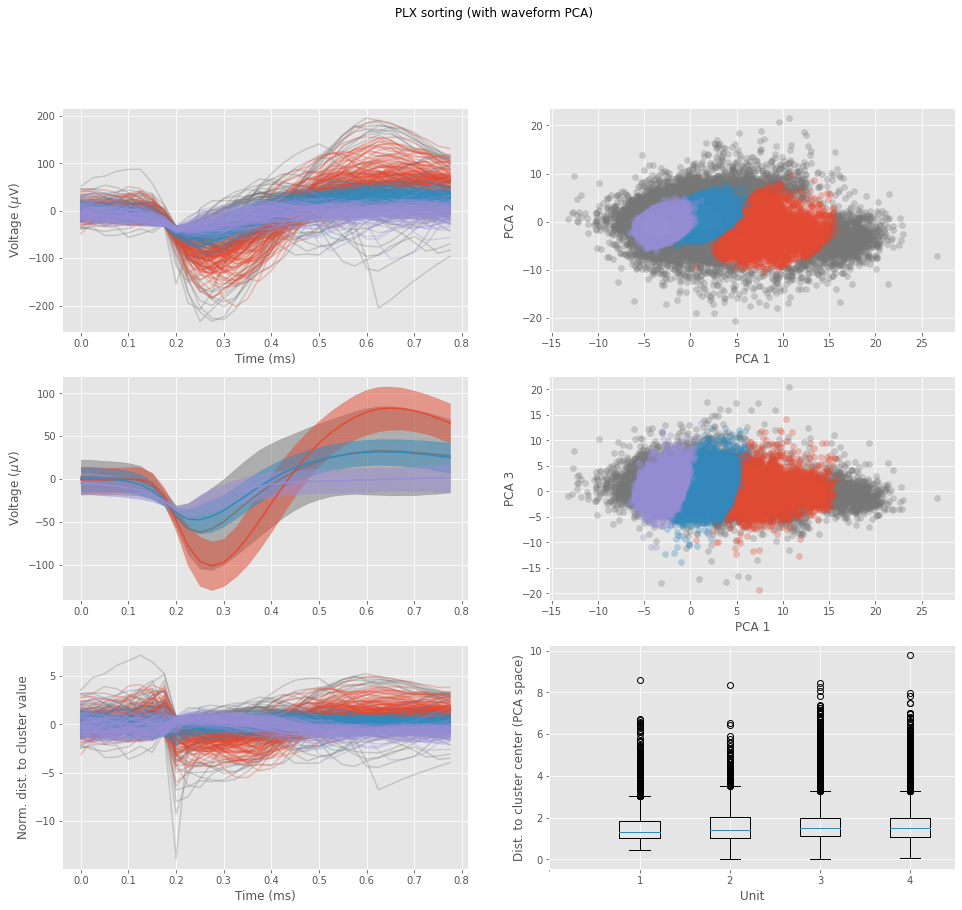

In [20]:
fig, ((wf_plot, pca1_plot), (mean_wf_plot, pca2_plot), (dist_wf_plot, pca_dist_wf_plot)) = plt.subplots(3, 2, figsize=(16, 14))

for unit, group in df.groupby('unit'):
    t = np.arange(waveform_size) / sampling_rate
    label = "Unsorted" if unit == 0 else f"Unit {unit}"
    color = f"C{[3, 0, 1, 2, 4, 5][unit]}"
    
    wf_mean = np.mean(group[wf_columns], axis=0)
    wf_stdv = np.std(group[wf_columns], axis=0)
        
    plot_wfs(group[wf_columns].values, title='', label=label, color=color, axes=wf_plot)
    
    mean_wf_plot.fill_between(t, wf_mean - wf_stdv, wf_mean + wf_stdv, color=color, alpha=0.5)
    mean_wf_plot.plot(t, wf_mean, color=color, label=label)
    mean_wf_plot.set_ylabel(r"Voltage ($\mu$V)")
    
    plot_wfs(wf_data[group.index], title='', color=color, axes=dist_wf_plot, ylabel="Norm. dist. to cluster value")
    
    scatter_pca(group[pca_wf_columns].values, (0, 1), title='', label=label, color=color, axes=pca1_plot)
    scatter_pca(group[pca_wf_columns].values, (0, 2), title='', label=label, color=color, axes=pca2_plot)
    
pca_dist_wf_plot.boxplot(
    [
        np.sqrt(
            np.sum(
                ((group[pca_wf_columns] - np.mean(group[pca_wf_columns], axis=0)) / np.std(group[pca_wf_columns], axis=0))**2,
                axis=1
            )
        )
        for _, group in df.groupby('unit')
    ]
)
pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))
pca_dist_wf_plot.set_xlabel("Unit")
pca_dist_wf_plot.set_ylabel("Dist. to cluster center (PCA space)")
    
fig.suptitle('PLX sorting (with waveform PCA)')
plt.show()

Then, assuming it was based on waveform feature projection

<ipython-input-21-8655cd3cfa13>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))


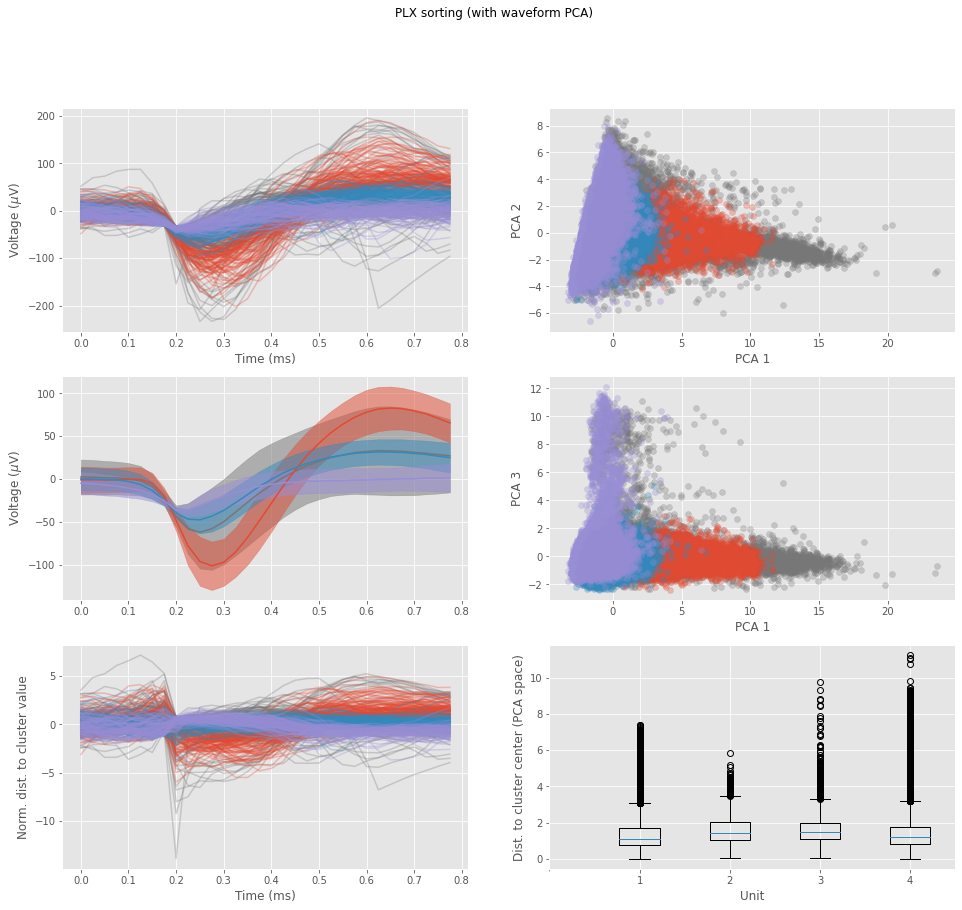

In [21]:
fig, ((wf_plot, pca1_plot), (mean_wf_plot, pca2_plot), (dist_wf_plot, pca_dist_wf_plot)) = plt.subplots(3, 2, figsize=(16, 14))

for unit, group in df.groupby('unit'):
    t = np.arange(waveform_size) / sampling_rate
    label = "Unsorted" if unit == 0 else f"Unit {unit}"
    color = f"C{[3, 0, 1, 2, 4, 5][unit]}"
    
    wf_mean = np.mean(group[wf_columns], axis=0)
    wf_stdv = np.std(group[wf_columns], axis=0)
        
    plot_wfs(group[wf_columns].values, title='', label=label, color=color, axes=wf_plot)
    
    mean_wf_plot.fill_between(t, wf_mean - wf_stdv, wf_mean + wf_stdv, color=color, alpha=0.5)
    mean_wf_plot.plot(t, wf_mean, color=color, label=label)
    mean_wf_plot.set_ylabel(r"Voltage ($\mu$V)")
    
    plot_wfs(wf_data[group.index], title='', color=color, axes=dist_wf_plot, ylabel="Norm. dist. to cluster value")
    
    scatter_pca(group[pca_ft_columns].values, (0, 1), title='', label=label, color=color, axes=pca1_plot)
    scatter_pca(group[pca_ft_columns].values, (0, 2), title='', label=label, color=color, axes=pca2_plot)
    
pca_dist_wf_plot.boxplot(
    [
        np.sqrt(
            np.sum(
                ((group[pca_ft_columns] - np.mean(group[pca_ft_columns], axis=0)) / np.std(group[pca_ft_columns], axis=0))**2,
                axis=1
            )
        )
        for _, group in df.groupby('unit')
    ]
)
pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))
pca_dist_wf_plot.set_xlabel("Unit")
pca_dist_wf_plot.set_ylabel("Dist. to cluster center (PCA space)")
    
fig.suptitle('PLX sorting (with waveform PCA)')
plt.show()

### Waveform PCA sorting

<ipython-input-22-86a02c2100b5>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))


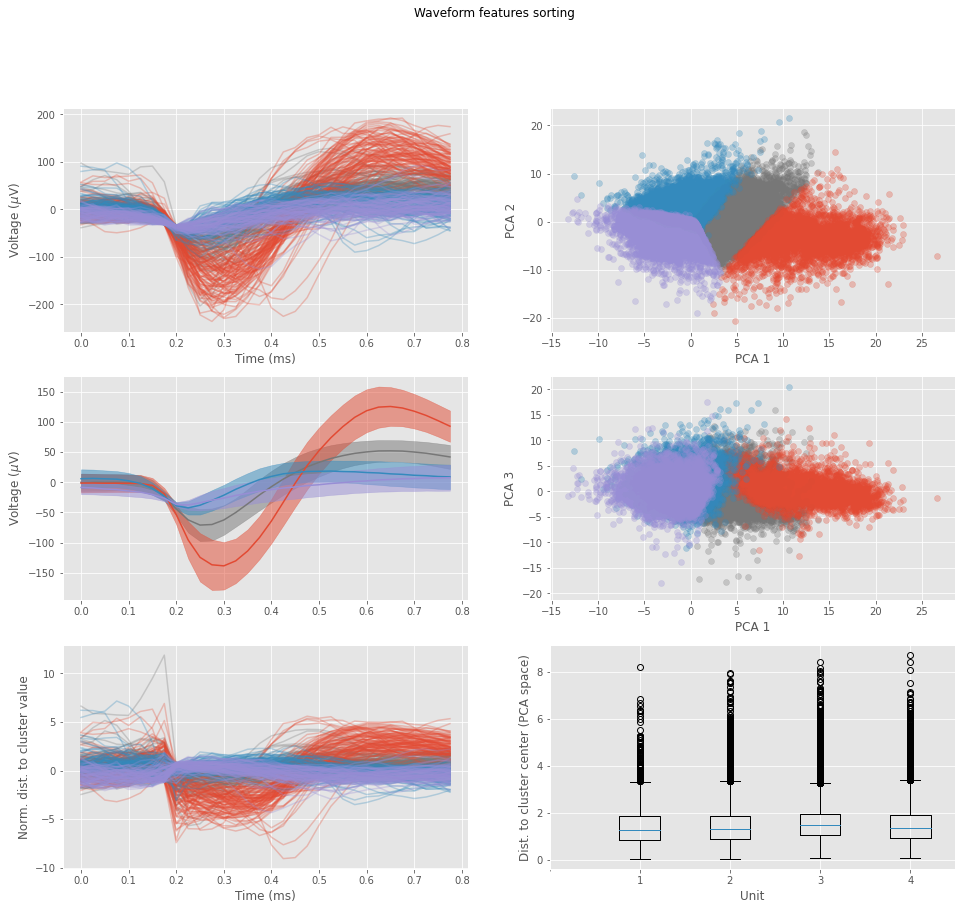

In [22]:
fig, ((wf_plot, pca1_plot), (mean_wf_plot, pca2_plot), (dist_wf_plot, pca_dist_wf_plot)) = plt.subplots(3, 2, figsize=(16, 14))

for unit, group in df.groupby('unit_wf'):
    t = np.arange(waveform_size) / sampling_rate
    label = "Unsorted" if unit == 0 else f"Unit {unit}"
    color = f"C{[3, 0, 1, 2, 4, 5][unit]}"
    
    wf_mean = np.mean(group[wf_columns], axis=0)
    wf_stdv = np.std(group[wf_columns], axis=0)
        
    plot_wfs(group[wf_columns].values, title='', label=label, color=color, axes=wf_plot)
    
    mean_wf_plot.fill_between(t, wf_mean - wf_stdv, wf_mean + wf_stdv, color=color, alpha=0.5)
    mean_wf_plot.plot(t, wf_mean, color=color, label=label)
    mean_wf_plot.set_ylabel(r"Voltage ($\mu$V)")
    
    plot_wfs(wf_data[group.index], title='', color=color, axes=dist_wf_plot, ylabel="Norm. dist. to cluster value")
    
    scatter_pca(group[pca_wf_columns].values, (0, 1), title='', label=label, color=color, axes=pca1_plot)
    scatter_pca(group[pca_wf_columns].values, (0, 2), title='', label=label, color=color, axes=pca2_plot)
    
pca_dist_wf_plot.boxplot(
    [
        np.sqrt(
            np.sum(
                ((group[pca_wf_columns] - np.mean(group[pca_wf_columns], axis=0)) / np.std(group[pca_wf_columns], axis=0))**2,
                axis=1
            )
        )
        for _, group in df.groupby('unit_ft')
    ]
)
pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))
pca_dist_wf_plot.set_xlabel("Unit")
pca_dist_wf_plot.set_ylabel("Dist. to cluster center (PCA space)")
    
fig.suptitle('Waveform features sorting')
plt.show()

### Waveform features PCA sorting

<ipython-input-23-5e0e8151eb08>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))


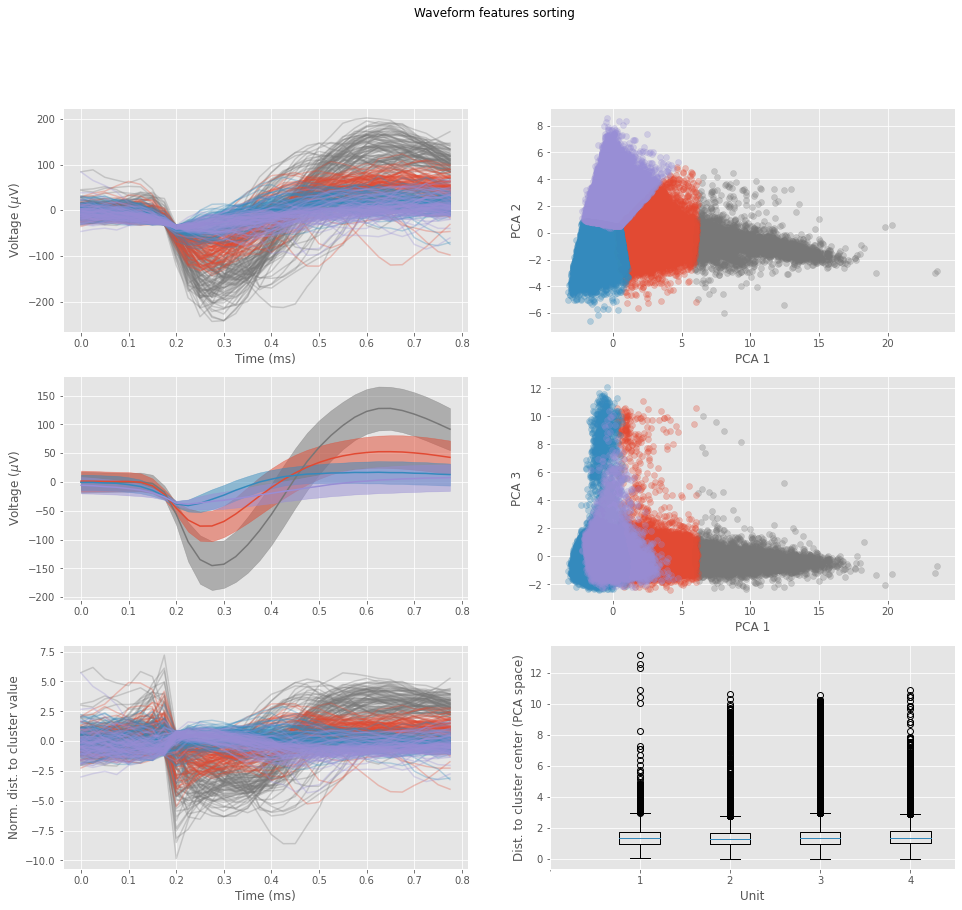

In [23]:
fig, ((wf_plot, pca1_plot), (mean_wf_plot, pca2_plot), (dist_wf_plot, pca_dist_wf_plot)) = plt.subplots(3, 2, figsize=(16, 14))

for unit, group in df.groupby('unit_ft'):
    t = np.arange(waveform_size) / sampling_rate
    label = "Unsorted" if unit == 0 else f"Unit {unit}"
    color = f"C{[3, 0, 1, 2, 4, 5][unit]}"
    
    wf_mean = np.mean(group[wf_columns], axis=0)
    wf_stdv = np.std(group[wf_columns], axis=0)
        
    plot_wfs(group[wf_columns].values, title='', label=label, color=color, axes=wf_plot)
    
    mean_wf_plot.fill_between(t, wf_mean - wf_stdv, wf_mean + wf_stdv, color=color, alpha=0.5)
    mean_wf_plot.plot(t, wf_mean, color=color, label=label)
    mean_wf_plot.set_ylabel(r"Voltage ($\mu$V)")
    
    plot_wfs(wf_data[group.index], title='', color=color, axes=dist_wf_plot, ylabel="Norm. dist. to cluster value")
    
    scatter_pca(group[pca_ft_columns].values, (0, 1), title='', label=label, color=color, axes=pca1_plot)
    scatter_pca(group[pca_ft_columns].values, (0, 2), title='', label=label, color=color, axes=pca2_plot)
    
pca_dist_wf_plot.boxplot(
    [
        np.sqrt(
            np.sum(
                ((group[pca_ft_columns] - np.mean(group[pca_ft_columns], axis=0)) / np.std(group[pca_ft_columns], axis=0))**2,
                axis=1
            )
        )
        for _, group in df.groupby('unit_ft')
    ]
)
pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))
pca_dist_wf_plot.set_xlabel("Unit")
pca_dist_wf_plot.set_ylabel("Dist. to cluster center (PCA space)")
    
fig.suptitle('Waveform features sorting')
plt.show()

### Combined sorting

<ipython-input-24-395978e5966b>:33: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))


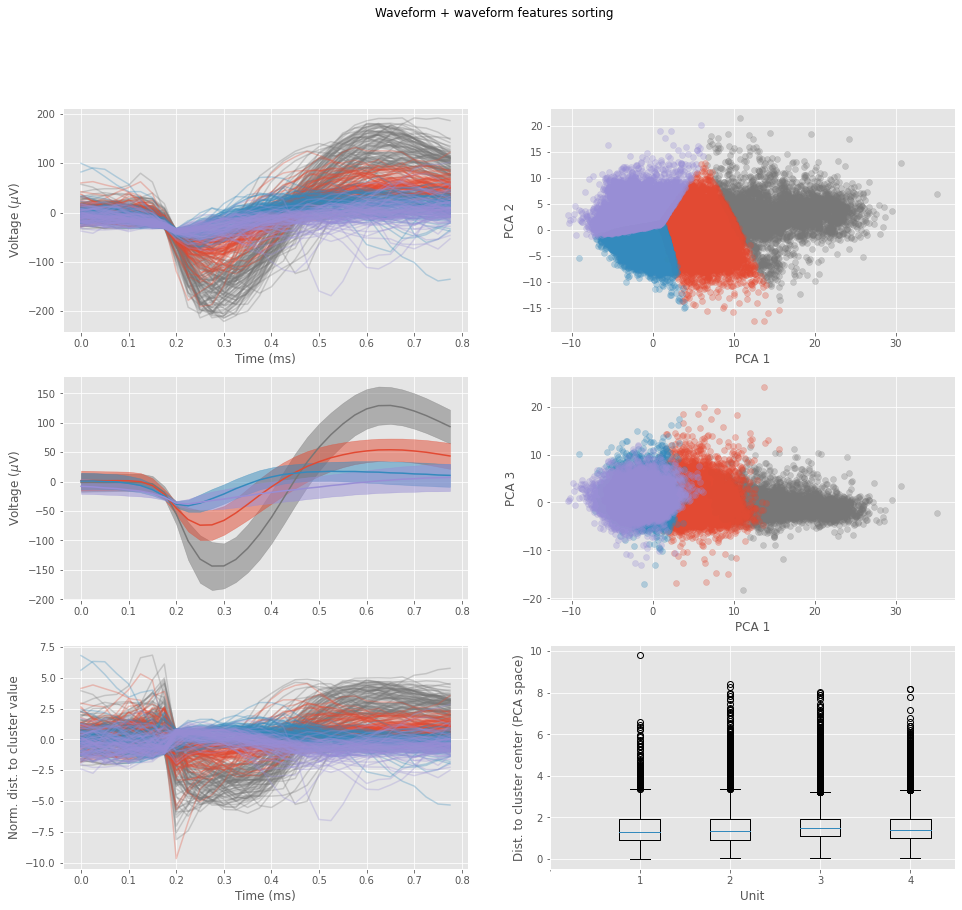

In [24]:
fig, ((wf_plot, pca1_plot), (mean_wf_plot, pca2_plot), (dist_wf_plot, pca_dist_wf_plot)) = plt.subplots(3, 2, figsize=(16, 14))

for unit, group in df.groupby('unit_mx'):
    t = np.arange(waveform_size) / sampling_rate
    label = "Unsorted" if unit == 0 else f"Unit {unit}"
    color = f"C{[3, 0, 1, 2, 4, 5][unit]}"
    
    wf_mean = np.mean(group[wf_columns], axis=0)
    wf_stdv = np.std(group[wf_columns], axis=0)
        
    plot_wfs(group[wf_columns].values, title='', label=label, color=color, axes=wf_plot)
    
    mean_wf_plot.fill_between(t, wf_mean - wf_stdv, wf_mean + wf_stdv, color=color, alpha=0.5)
    mean_wf_plot.plot(t, wf_mean, color=color, label=label)
    mean_wf_plot.set_ylabel(r"Voltage ($\mu$V)")
    
    plot_wfs(wf_data[group.index], title='', color=color, axes=dist_wf_plot, ylabel="Norm. dist. to cluster value")
    
    scatter_pca(group[pca_mx_columns].values, (0, 1), title='', label=label, color=color, axes=pca1_plot)
    scatter_pca(group[pca_mx_columns].values, (0, 2), title='', label=label, color=color, axes=pca2_plot)
    
pca_dist_wf_plot.boxplot(
    [
        np.sqrt(
            np.sum(
                ((group[pca_mx_columns] - np.mean(group[pca_mx_columns], axis=0)) / np.std(group[pca_mx_columns], axis=0))**2,
                axis=1
            )
        )
        for _, group in df.groupby('unit_ft')
    ]
)
pca_dist_wf_plot.set_xticks(range(n_units), range(1, n_units + 1))
pca_dist_wf_plot.set_xlabel("Unit")
pca_dist_wf_plot.set_ylabel("Dist. to cluster center (PCA space)")
    
fig.suptitle('Waveform + waveform features sorting')
plt.show()

## Quantitative evaluation  of feature spaces

The following metrics provide quantitative measurements of how much a sorting algorithm based on a certain features space aggrees with the embedded sorting (dubbed _PLX_, first row).
Note that silhoutte is a very good metric, but computationally expesive, hence it was commented out.

In [25]:
pd.DataFrame([
    {
        "Sorting": name,
        "Agreement": metrics.adjusted_mutual_info_score(df['unit'], df[key]),
        "Homogeneity": metrics.homogeneity_score(df['unit'], df[key]),
        "Completeness": metrics.completeness_score(df['unit'], df[key]),
        "Davies-Bouldin": metrics.davies_bouldin_score(df[pca_cols], df[key]),
#         "Sihouette": metrics.silhouette_score(df[pca_cols], df[key]),
    }
    for name, key, pca_cols in zip(
        ["PLX", "Waveform", "Features", "Combined"],
        ["unit", "unit_wf", "unit_ft", "unit_mx"],
        [pca_wf_columns, pca_wf_columns, pca_ft_columns, pca_mx_columns],
    )
])

Sorting  Agreement  Homogeneity  Completeness  Davies-Bouldin
0       PLX   1.000000     1.000000      1.000000        5.238673
1  Waveform   0.275326     0.271820      0.278979        1.214488
2  Features   0.243016     0.231192      0.256179        0.817964
3  Combined   0.268672     0.262624      0.275062        1.083750

Now, if we take the waveform-based algorithm as the target, the evaluation is as follows:

In [26]:
pd.DataFrame([
    {
        "Sorting": name,
        "Agreement": metrics.adjusted_mutual_info_score(df['unit_wf'], df[key]),
        "Homogeneity": metrics.homogeneity_score(df['unit_wf'], df[key]),
        "Completeness": metrics.completeness_score(df['unit_wf'], df[key]),
        "Davies-Bouldin": metrics.davies_bouldin_score(df[pca_cols], df[key]),
#         "Sihouette": metrics.silhouette_score(df[pca_cols], df[key]),
    }
    for name, key, pca_cols in zip(
        ["Waveform", "PLX", "Features", "Combined"],
        ["unit_wf", "unit", "unit_ft", "unit_mx"],
        [pca_wf_columns, pca_wf_columns, pca_ft_columns, pca_mx_columns],
    )
])

Sorting  Agreement  Homogeneity  Completeness  Davies-Bouldin
0  Waveform   1.000000     1.000000      1.000000        1.214488
1       PLX   0.275326     0.278979      0.271820        5.238673
2  Features   0.345497     0.332778      0.359281        0.817964
3  Combined   0.587291     0.581412      0.593321        1.083750

These two tables show there is more agreement among the investigated sorting algorithms (based on waveforms, waveform features, and their combinations) than between each of them and the embedded sorting information.

Another relevant measurement is that of how much variance is accounted for by each projection axis. The following table show the fraction of variance explained by each PCA 

In [27]:
pd.DataFrame([
    (name,) + tuple(projection.explained_variance_ratio_) + (1 - sum(projection.explained_variance_ratio_),)
    for name, projection in [
        ("Waveform", wf_projection),
        ("Features", ft_projection),
        ("Combined", mx_projection),
    ]
], columns=("Scheme", "PCA1", "PCA2", "PCA3", "Residue"))

Scheme      PCA1      PCA2      PCA3   Residue
0  Waveform  0.443582  0.209308  0.124085  0.223024
1  Features  0.410344  0.223475  0.085505  0.280675
2  Combined  0.415405  0.182332  0.090709  0.311553

## Saving data

In [28]:
df[['unit', 'unit_wf', 'unit_ft', 'unit_mx']].to_csv(f"data/{data_name}_{channel}.sorting.csv", index=False)

PermissionError: [Errno 13] Permission denied: 'data/grating-v206-he1800-hd2600-kmeans_sub_47.sorting.csv'

## Conclusions

* Both waveform and waveform feature projections produce poorly separable results, with
    * Little resemblance to the embedded sorting, and
    * A considerable amount of overlap between waveform units that seem to be separable, at least uppon visual inspection of the plotted waveforms.
* Although PCA is commonly used in spike sorting, it is known that it may perform poorly with K-means, since greatest variance does not necessarily translate to greater separability.

Therefore, other projections must be tested (preferrably, in automatic fashion) to determine which one results in higher separability of waveforms.

**Note:** Offline Sorter's manual says they use an enhanced PCA by Plexon that is geared for separability.

### Future directions

* Measure self/cross-similarity of clusters in feature space